In [1]:
# eta should converge when it is 
# integ
# MMS - perturb (2nd and 4th )
# eigen-value/vector output - BC should be the same
# del_dp_dr should be 0g

In [2]:
# needs to get added to helper
def GetInputVariables(string):
    #opening the file that has the inputs to the FORTRAN Code
    InputFile = open("../../FortranFiles/main-scripts/main-variables.f90","r")
    
    flag  = 0
    index = 0
    
    for line in InputFile:
        index += 1
        
        # checking if the string is present in line or not
        if string in line:
            result = line
            flag = 1  
            break
    # checking condition for string found or not, uncomment else when debugging
    if flag == 0:
        print('String', string, 'Not Found')
    #else:
        #print('String', string, 'Found In Line', index)
        
    # using re.findall()
    # getting numbers from string 
    result = re.findall(r'\d*\.?\d+', result)
    
    return result

def plotSymbolicEquation(title  , \
                         x_data , \
                         x_title, \
                         y_data , \
                         y_title, \
                         x_min  , \
                         x_max):
    
    # convert symbolic expressions using numpy
    lam_x = lambdify(x_data,y_data , modules=['numpy'])
    x_vals = linspace((x_min), (x_max), 100)
    y_vals = lam_x(x_vals) 
    
    fig = mpl.figure(figsize=(10,6))
    ax = mpl.axes()
    
    ax.grid(True,which='major',axis='both',alpha=0.3) 
    mpl.title(title)
    mpl.xlabel(x_title)
    mpl.ylabel(y_title)
    mpl.plot(x_vals, y_vals)
    mpl.show(fig)
    
    return 

def SourceSubstitution(S, \
                       A_analytic         , \
                       M_t_analytic       , \
                       M_x_analytic     , \
                       v_r_analytic     , \
                       v_t_analytic     , \
                       v_x_analytic     , \
                       p_analytic       , \
                       dp_dr_analytic   , \
                       dv_r_dr_analytic , \
                       dM_x_dr_analytic , \
                       dM_t_dr_analytic , \
                      ): 
    
    #print('Input Source: ', S)
    S = S.subs({ \
            A:A_analytic       , \
            M_t:M_t_analytic   , \
            M_x:M_x_analytic , \
            v_r:v_r_analytic , \
            v_t:v_t_analytic , \
            v_x:v_x_analytic , \
            p:p_analytic     , \
            dp_dr:dp_dr_analytic, \
            dv_r_dr:dv_r_dr_analytic, \
            dM_x_dr:dM_x_dr_analytic, \
            dM_t_dr:dM_t_dr_analytic, \
               })
    #print('Output Source', S)
    return S

In [3]:
# Importing libraries
from fractions import Fraction 
from sympy import *
from sympy.plotting import plot
from sympy.utilities.codegen import codegen
from sympy.utilities.autowrap import autowrap
from sympy.interactive import printing
from numpy import linspace
printing.init_printing(use_latex = True) 
# general libraries
import sympy as sp
import numpy as np
import math
import re
import numpy as np
import matplotlib.pyplot as mpl 
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
from decimal import Decimal
import helpers as fcn

# custom libraries 


In [4]:
# Defining symbolic variables needed for this code.
# all units are dimensionless! 

# radius, maximum radius, and ratio of specific heats
r, r_max,r_min, kappa = symbols('r r_max r_min kappa')

# arbitrary constants
k = symbols('k', cls=IndexedBase)
one, \
two, \
three\
  = symbols('one two three')
C = symbols('C')
x = symbols('x')

# reduced frequency
ak = symbols('ak')

# imaginary #, Speed of sound, azimuthal mode number, axial wavenumber 
i, A, m, gamma   = symbols('i A m gamma')
v_r, v_t, v_x, p = symbols('v_r v_t v_x p ')
M_t, M_x         = symbols('M_t M_x')
dp_dr, dv_r_dr   = symbols('dp_dr dv_r_dr')
dM_x_dr, dM_t_dr = symbols('dM_x_dr dM_t_dr')


#unused?
j     = symbols('j')
ci    = symbols('ci')
eta   = symbols('eta')

In [5]:
# capturing inputs from fortran
r_max_string    = 'r_max'
r_min_string    = 'r_min'
kappa_string    = 'gam'
eta_max_string  = 'ductAdmittance'
eta_min_string  = 'hubAdmittance'
ak_string       = 'frequency'

r_max   = float(GetInputVariables(r_max_string)  [0])
r_min   = float(GetInputVariables(r_min_string)  [0])
kappa   = float(GetInputVariables(kappa_string)  [0])
eta_min = float(GetInputVariables(eta_min_string)[0])
eta_max = float(GetInputVariables(eta_max_string)[0])
ak      = float(GetInputVariables(ak_string)     [0])
gamma   = ak*r_max 
ci      = (-1)**0.5

In [6]:
A_analytic        = 0.95*fcn.TanhMethod(8,0.3,r_min,r_max) 
dA_analytic_dr    = diff(A_analytic,r)
dA_analytic_sq_dr = diff(A_analytic**2,r)

M_t_analytic      = (\
                     (r/((kappa - 1)*A_analytic**2)* \
                     (dA_analytic_sq_dr))**0.5 \
                    )
# scalar multiplier below
M_x_analytic      = 0.01*fcn.TanhMethod(5 ,50,r_min,r_max )
     
M_total           = (M_x_analytic**(2) + M_t_analytic**(2))**(0.5)

In [7]:
f     = fcn.TanhMethod(5,1
                       ,r_min,r_max)
df    = f.diff(r)
r_hat = (r - r_min)/(r_max - r_min)
f_min = f.subs(r,r_min)
f_max = f.subs(r,r_max)

f_min_desired  = 0
f_max_desired  = 0

A_max          = 3*r_hat**2 - 2*r_hat**3
A_min          =  1 - A_max  

del_f_min = (f_min_desired - f_min)
del_f_max = (f_max_desired - f_max)

f_imposed = fcn.ModifiedManufacturedSolution(f_MS          = f, \
                                             f_minBC       = f_min_desired, \
                                             f_maxBC       = f_max_desired, \
                                             f_minMS       = f_min        , \
                                             f_maxMS       = f_max        , \
                                             A_min         = A_min        , \
                                             A_max         = A_max)

In [8]:
v_t_analytic = fcn.TanhMethod(5,20,r_min,r_max)
v_x_analytic = fcn.TanhMethod(5,20,r_min,r_max)

# v_r and dp_dr need to be zero at the wall!
v_r_analytic = f_imposed

# TODO: Put if statement to allow constantS for functions
dv_r_dr_analytic = v_r_analytic.diff(r) 
dM_x_dr_analytic = M_x_analytic.diff(r)
dM_t_dr_analytic = M_t_analytic.diff(r)

In [9]:
sigma  = r_min
f      = fcn.TanhMethod(5,1,r_min,r_max)
df     = f.diff(r)
r_hat  = (r - r_min)/(r_max - r_min)
f_min  = f.subs(r,r_min)
f_max  = f.subs(r,r_max)
df_min = df.subs(r,r_min)
df_max = df.subs(r,r_max)

B_min  = (1 - sigma)*\
(\
 ((r -  sigma)/((1) - sigma) )   - \
2*((r - sigma)/((1) - sigma))**(2) +\
  ((r - sigma)/((1) - sigma))**(3)  \
)

B_max = (1 - sigma)* \
(\
-1*((r - sigma)/(1 - sigma))**2 +\
  ((r - sigma)/(1 - sigma))**3  \
)

psi_1 = \
(2/r)*M_t_analytic*v_t_analytic     -  \
((kappa - 1)/r)*(M_t_analytic**2)*f - df

psi_2 = dv_r_dr_analytic + ci*gamma*v_x_analytic +\
(((kappa + 1)/(2*r))*M_t_analytic**2 + 1/r)*v_t_analytic

L = eta*((1-(gamma/ak))*M_total)*f

del_dp_BC    = psi_1 + L*psi_2

del_dp_minBC = del_dp_BC.subs({'r'    :r_min  , \
                               'ak'   :ak     , \
                               'eta'  :eta_min, \
                               'kappa':kappa  , \
                               'ci'   :ci       \
                               })
del_dp_maxBC = del_dp_BC.subs({'r'    :r_max  , \
                               'ak'   :ak     , \
                               'eta'  :eta_max, \
                               'kappa':kappa  , \
                               'ci'   :ci       \
                               })
                                

p_analytic = \
fcn.diffModifiedManufacturedSolution(f           , \
                                     del_dp_minBC, \
                                     del_dp_maxBC, \
                                     B_min       , \
                                     B_max)

p_analytic = p_analytic.subs({'ak':ak,\
                              'gamma':gamma,\
                              'ci':ci})

In [10]:
dp_dr_analytic   = p_analytic.diff(r)

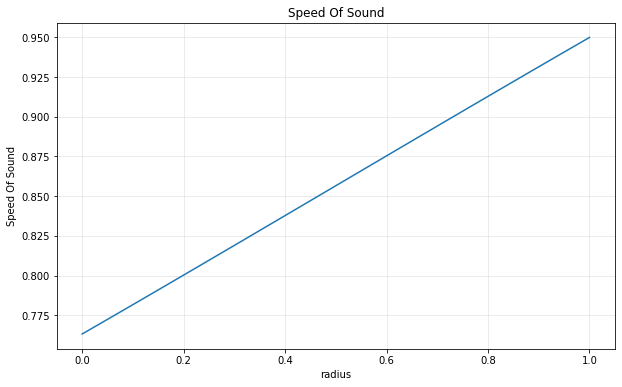

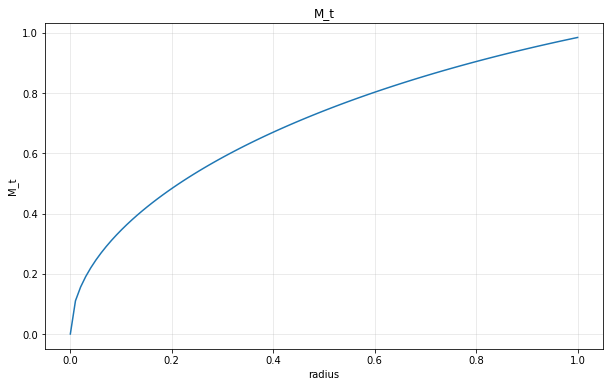

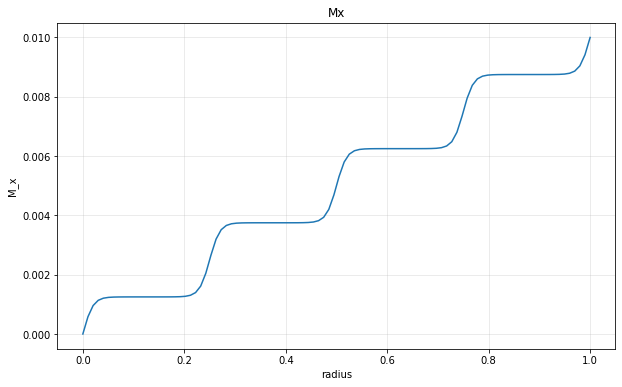

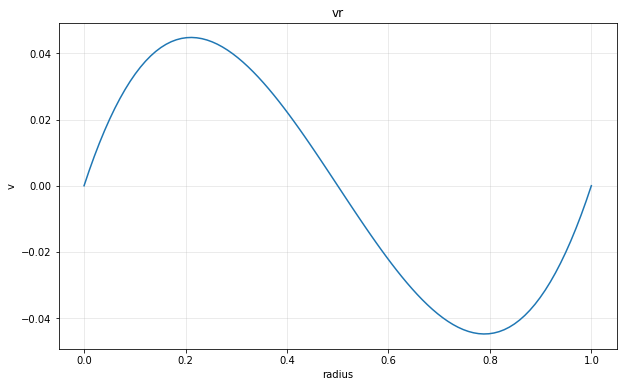

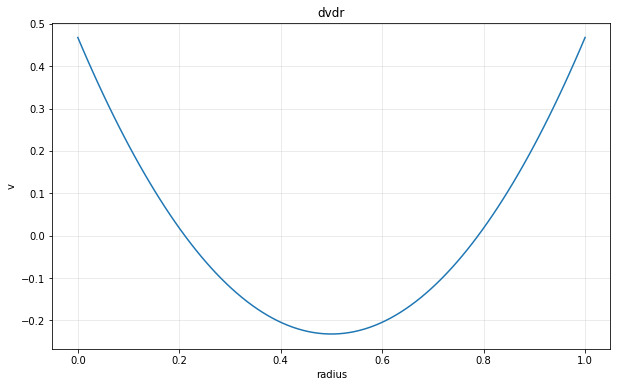

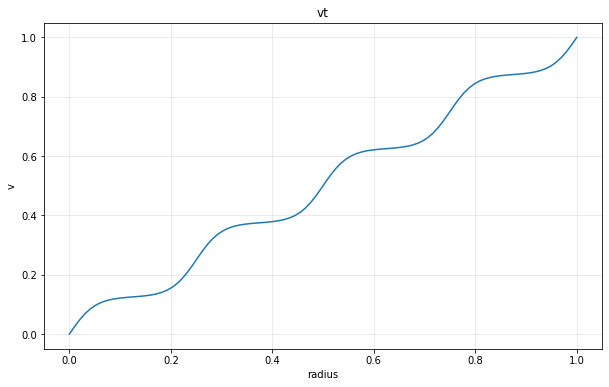

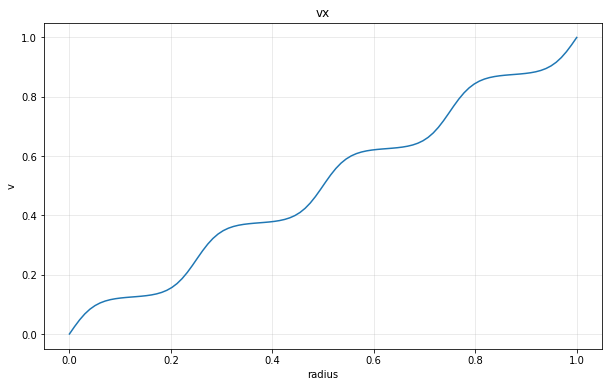

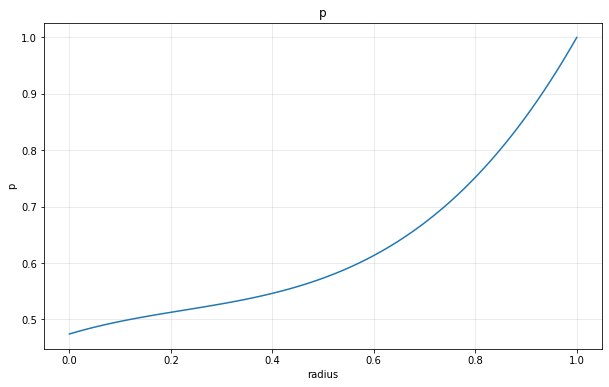

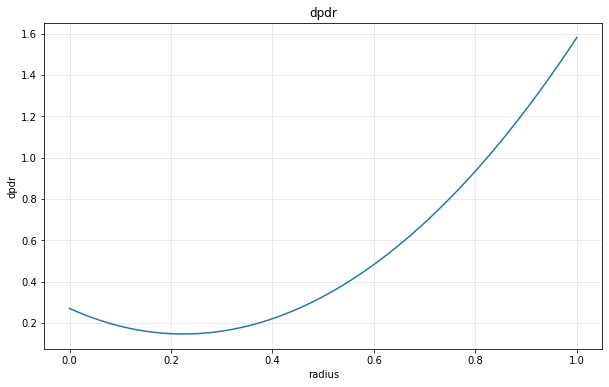

In [11]:
plotSymbolicEquation('Speed Of Sound', \
                     r               , \
                     'radius'        , \
                     A_analytic      , \
                     'Speed Of Sound', \
                     r_min           , \
                     r_max)

plotSymbolicEquation('M_t'       , \
                     r           , \
                     'radius'    , \
                     M_t_analytic, \
                     'M_t'       , \
                     r_min       , \
                     r_max)

plotSymbolicEquation('Mx'        , \
                     r           , \
                     'radius'    , \
                     M_x_analytic, \
                     'M_x'       , \
                     r_min       , \
                     r_max)
plotSymbolicEquation('vr'  ,r,'radius',v_r_analytic,'v',r_min,r_max)
plotSymbolicEquation('dvdr'  ,r,'radius',dv_r_dr_analytic,'v',r_min,r_max)
plotSymbolicEquation('vt'  ,r,'radius',v_t_analytic,'v',r_min,r_max)
plotSymbolicEquation('vx'  ,r,'radius',v_x_analytic,'v',r_min,r_max)
plotSymbolicEquation('p'   ,r,'radius',p_analytic,'p',r_min,r_max)
plotSymbolicEquation('dpdr',r,'radius',dp_dr_analytic,'dpdr',r_min,r_max)

In [12]:
S = list(range(4)) 
S[0] = \
-i*(ak/A - (m/r)*M_t - gamma*M_x)*v_r  -\
\
(two/r)*M_t*v_t + dp_dr + ((kappa - one)/r)*(M_t**two)*p

S[1] = \
-i*(ak/A - (m/r)*M_t - gamma*M_x)*v_t + \
\
(M_t/r + dM_t_dr + ((kappa - one)/(two*r))*M_t**three)*v_r + i*m*p/r

S[2] = \
-i*(ak/A - (m/r)*M_t - gamma*M_x)*v_x + \
\
(dM_x_dr + ((kappa - one)/(two*r))*M_x*M_t**two)*v_r + i*one*gamma*p
 
S[3] = \
-i*(ak/A - (m/r)*M_t - gamma*M_x)*p   \
\
+ dv_r_dr + (((kappa + one)/(two*r))*M_t**two + one/r)*v_r + i*m*v_t/r + i*one*gamma*v_x



In [13]:

AA = sp.Matrix(sp.zeros(4,4))

AA[0,0] = -i*(ak/A - (m/r)*M_t)
AA[1,1] = AA[0,0]
AA[2,2] = AA[0,0]
AA[3,3] = AA[0,0]

AA[0,2] = 0
AA[1,2] = 0
AA[3,2] = 0
AA[2,1] = 0
AA[2,3] = 0

AA[1,3] = (i*m)/r
AA[3,1] = AA[1,3]

A12 = (-two/r)*M_t
A21 = M_t/r + dM_t_dr + (kappa - one)/(two*r)*M_t**three
A31 = dM_x_dr + (kappa - one)/(two*r)*M_t**two*M_x

AA[0,1] = A12
AA[1,0] = A21
AA[2,0] = A31

# note that these terms only have derivative operators , See Eqn 2.52

A41 = (1/v_r)*dv_r_dr + one/r + (kappa + one)/(two*r)*M_t**two
A14 = (1/p)*dp_dr + (kappa - one)/r * M_t**two

AA[3,0] = A41
AA[0,3] = A14

BB = sp.zeros(4,4)

BB[0,0] = M_x
BB[1,1] = BB[0,0]
BB[2,2] = BB[0,0]
BB[3,3] = BB[0,0]

BB[2,3] = one
BB[3,2] = BB[2,3]

XX = sp.Matrix([\
               [v_r] , \
               [v_t] , \
               [v_x] , \
               [p] , \
               ])

Lambda = -i*gamma

SS = AA*XX - Lambda*BB*XX

In [14]:
#now that we set the matricies up lets get our individual terms 
A_times_x        = sp.Matrix(sp.zeros(len(S),len(S)))
lambda_B_times_x = sp.Matrix(sp.zeros(len(S),len(S)))

for j in range(len(S)):
    for i in range(len(S)):
        A_times_x[i,j]        = [AA[i,j]*XX[j]]
        lambda_B_times_x[i,j] = Lambda*BB[i,j]*XX[j]

for i in range(len(S)):
    match =(S[i].equals( \
                  A_times_x[i,0] + \
                  A_times_x[i,1] + \
                  A_times_x[i,2] + \
                  A_times_x[i,3] -\
                 (lambda_B_times_x[i,0] + \
                  lambda_B_times_x[i,1] + \
                  lambda_B_times_x[i,2] + \
                  lambda_B_times_x[i,3])))
    print(match)
# notes on differences between system of equations and Ax-lambda Bx    
# multiplying (1/p) and not (one/p) by dp_dr made  S_1 and SS[1] the same
# multiplied i gamma p term by "one" in S_3
# multiplied by 1/v_r by d_v_dr and i v_x gamma terM by one


True
True
True
True


In [15]:

# Checking if the matrix expressions equal the linear system of equations
print(S[0].equals(SS[0]))
print(S[1].equals(SS[1]))
print(S[2].equals(SS[2]))
print(S[3].equals(SS[3]))

for i in range(len(S)):
    S[i] = SourceSubstitution(S[i], \
                       A_analytic         , \
                       M_t_analytic   , \
                       M_x_analytic     , \
                       v_r_analytic     , \
                       v_t_analytic     , \
                       v_x_analytic     , \
                       p_analytic       , \
                       dp_dr_analytic   , \
                       dv_r_dr_analytic , \
                       dM_x_dr_analytic , \
                       dM_t_dr_analytic , \
                       )

for i in range(len(A_times_x[:,0])):
    for j in range(len(A_times_x[0,:])):
        A_times_x[i,j] = SourceSubstitution(\
                       A_times_x[i,j], \
                       A_analytic         , \
                       M_t_analytic   , \
                       M_x_analytic     , \
                       v_r_analytic     , \
                       v_t_analytic     , \
                       v_x_analytic     , \
                       p_analytic       , \
                       dp_dr_analytic   , \
                       dv_r_dr_analytic , \
                       dM_x_dr_analytic , \
                       dM_t_dr_analytic , \
                                      ) 
        lambda_B_times_x[i,j] = SourceSubstitution(\
                       lambda_B_times_x[i,j], \
                       A_analytic         , \
                       M_t_analytic   , \
                       M_x_analytic     , \
                       v_r_analytic     , \
                       v_t_analytic     , \
                       v_x_analytic     , \
                       p_analytic       , \
                       dp_dr_analytic   , \
                       dv_r_dr_analytic , \
                       dM_x_dr_analytic , \
                       dM_t_dr_analytic , \
                                         )


True
True
True
True


In [16]:
%run create-fortran-scripts/create-fortran-file-sound-speed.ipynb

%run create-fortran-scripts/create-fortran-file-perturbation-variables.ipynb

S_1 = S[0]
S_2 = S[1]
S_3 = S[2]
S_4 = S[3]
%run create-fortran-scripts/create-fortran-file-LEE-source-terms.ipynb

%run create-fortran-scripts/create-fortran-file-LEE-source-terms-components.ipynb



SoundSpeedMMS.f90 below
 

! Returns M_theta and the corresponding sound speed as defined in

! SourceTermSymbolicSolver.ipynb



    SUBROUTINE CalcSoundSpeed(& 

    r                 , &

    kappa          , &

    SoundSpeedExpected, &

    thetaMachData     , &

    axialMachData)

    

    REAL(KIND=rDef)   , INTENT(IN) :: &

    kappa

    

    REAL(KIND=rDef)   , DIMENSION(:), INTENT(INOUT) :: &

    SoundSpeedExpected, thetaMachData, axialMachData

    

    REAL(KIND=rDef)   , DIMENSION(:), INTENT(IN) :: &

    r

    

     

    ! Local variables 

    INTEGER :: &

    numberOfGridPoints, i!, j

    

    REAL(KIND = rDef) :: one,two,three

        

    one   = (1.0_rDef)    

    two   = (2.0_rDef)    

    three = (3.0_rDef)



    

    numberOfGridPoints = SIZE(SoundSpeedExpected)



        DO i = 1,numberOfGridPoints



        SoundSpeedExpected(i) = 0.0791666666666667d0*tanh(0.30000000300000002d0*r(i)- &

      0.30000000300000002d0) + 0.0791666666666667d0*tanh